#### Data Description

The below data snippet provides information about first 5 loan applications.To view the entire dataset scroll to the end of the page. 
* application_id: The applications have a unique id.
* application_date: date when the application was done.
* credit_score: Its creditworthiness scoring done by banks and other organizations for an individual. This score helps to understand how much risk a consumer posses while lending money. This also determines who qualifies for loan and at what credit limit and upto what interest. Credit score mitigates companies loses due to bad debt and also determines which customer is going to bring most revenue.
* applied_amount: How much loan amount an individual applied for.
* loan_duration: How long the loan will last.
* nominal_interest: nominal interest rate refers to interest rate before taking inflation into account.
* effective_interest: Unlike nominal interest, effective interest takes compounding period into account. Hence it is considered more accurate measure for interest charges.
* financed: binarized expression which applicant was financed and who wasn't. 1: yes 0: no.

Note : Relationship between nominal and effective annual interest rate is : ia = [ 1 + (r / m) ]^ m - 1.
where ia= effective interest rate, r= nominal interest rate, m= compounding perdiod per year(12 months per year).The more often compounding occurs, the higher the effective interest rate.

In [1]:
#list of libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import math
import sklearn

In [2]:
loan_data=pd.read_csv("/home/soumya/Documents/gitfolder/Analytics/Datasets/loan_dataset.csv",sep=';')

loan_data.head()

,application_id,application_date,credit_score,applied_amount,loan_duration,nominal_interest,monthly_fee,effective_interest,financed
0,1,1.1.2020,529,12000,48,13.26,6,15.23,0
1,2,1.1.2020,621,14500,72,11.07,6,12.54,0
2,3,1.1.2020,525,13000,120,13.95,6,15.75,0
3,4,1.1.2020,563,5500,84,9.66,6,12.40,0
4,5,1.1.2020,600,15000,108,12.66,6,14.21,0


The dataset consists of 9 data columns and 5000 observations. 

In [3]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   application_id      5000 non-null   int64  
 1   application_date    5000 non-null   object 
 2   credit_score        5000 non-null   int64  
 3   applied_amount      5000 non-null   int64  
 4   loan_duration       5000 non-null   int64  
 5   nominal_interest    5000 non-null   float64
 6   monthly_fee         5000 non-null   int64  
 7   effective_interest  5000 non-null   float64
 8   financed            5000 non-null   int64  
dtypes: float64(2), int64(6), object(1)
memory usage: 351.7+ KB


## Analysis

Since our target is to predict from the dataset which applications will be financed and which will not be. Lets start from financed column. Lets check how many observations were financed and how many were not.

Text(0.5, 1.0, 'Count of Financed/Non-financed Applications')

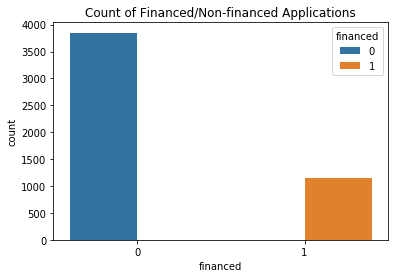

In [4]:
sns.countplot(x="financed",data=loan_data,hue="financed").set_title("Count of Financed/Non-financed Applications")

In [5]:
df = pd.concat([loan_data.financed.value_counts(), 
                loan_data.financed.value_counts(normalize=True).mul(100)],axis=1, keys=('counts','percentage%'))

print(df)

   counts  percentage%
0    3850         77.0
1    1150         23.0


So from the above picture its quite clear that ratio of unfinanced applications are more than financed. Credit score is a very interesting feature in the dataset, researching a little on credit score we can understand that depending on the score most of the financial institution lends their customers. Lets dig the feature.

Text(0.5, 1.0, 'Credit Score Histogram')

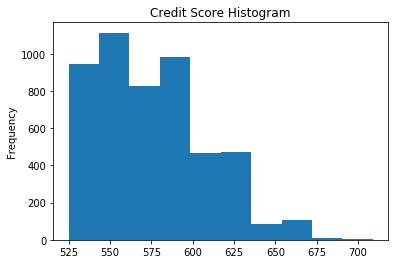

In [6]:
loan_data['credit_score'].plot.hist().set_title("Credit Score Histogram")

From the histogram we can easily make out, more than 1000 applicants have credit score 550, so its the most frequent credit score. The distribution is right skewed with mean at 575.78 and median at 571. Most of the applicants have low credit score.

In [7]:
print("Mean of the histogram",loan_data['credit_score'].mean())
print("Median of histogram",loan_data['credit_score'].median())

Mean of the histogram 575.7878
Median of histogram 571.0


In [8]:
df=loan_data.loc[loan_data['financed'] == 0]

print("Maximum credit score of not-financed people:",max(df['credit_score']))
print("Minimum credit score of not-financed people:",min(df['credit_score']))
print("Average credit score of not-financed people:",df['credit_score'].mean())

Maximum credit score of not-financed people: 709
Minimum credit score of not-financed people: 525
Average credit score of not-financed people: 573.4046753246753


In [9]:
df=loan_data.loc[loan_data['financed'] == 1]

print("Maximum credit score of financed people:",max(df['credit_score']))
print("Minimum credit score of financed people:",min(df['credit_score']))
print("Average credit score of financed people:",df['credit_score'].mean())

Maximum credit score of financed people: 709
Minimum credit score of financed people: 525
Average credit score of financed people: 583.7660869565217


Though mean credit score of the financed applications is greater than non-financed, but having a higher credit score is not the only criteria for being financed.Since applications with credit score 525 is also getting financed. Lets dig into other features : applied_amount, loan duration and interest.

Text(0.5, 1.0, 'Applied Amount Histogram')

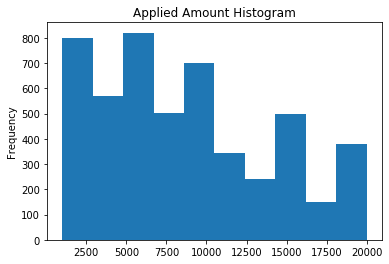

In [10]:
loan_data['applied_amount'].plot.hist().set_title("Applied Amount Histogram")

In [11]:
loan_data.isnull().sum()

application_id        0
application_date      0
credit_score          0
applied_amount        0
loan_duration         0
nominal_interest      0
monthly_fee           0
effective_interest    0
financed              0
dtype: int64

So we don't need to do any data cleaning like removing NAs, since there are no NAs.

## Logistic Regression

Since the dataset is classified into two applications type financed and not-financed denoted by binary 1 and 0 respectively, we use logistic regression to predict which applicants are likely to be financed and who are not.

**Test/Train dataset :**

We need to create test and train dataset.In order to do so we need to start extracting features from the dataset i.e columns which are relevant and can be used to create proper prediction model.

In [12]:
#independent variable:
X=loan_data.iloc[:,2:4]


X.head()

X.info()

#dependent variable
Y=loan_data.iloc[:,8]

Y.head()

#Y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   credit_score    5000 non-null   int64
 1   applied_amount  5000 non-null   int64
dtypes: int64(2)
memory usage: 78.2 KB


0    0
1    0
2    0
3    0
4    0
Name: financed, dtype: int64

In [13]:
from sklearn.model_selection import train_test_split

X_train,X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.25,random_state=0)

In [14]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [15]:
from sklearn.linear_model import LogisticRegression

classifier= LogisticRegression(random_state=0)

classifier.fit(X_train,Y_train)

y_pred=classifier.predict(X_test)


from sklearn.metrics import accuracy_score

accuracy_score(Y_test,y_pred)*100

77.92